In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.interpolate import RegularGridInterpolator

from pathlib import Path
from MITRotor import BEM, IEA10MW, IEA15MW, BEMGeometry, AerodynamicProperties, NoTipLoss, PrandtlTipLoss, ConstantInduction, KraghAerodynamics, ClassicalMomentum, UnifiedMomentum, MadsenMomentum, NoTangentialInduction, DefaultTangentialInduction, BEMSolution


In [3]:
def per_error(A, E):
    error = abs((A - E) / E) * 100

    return error

In [59]:
casenames = [r's0_v4']

wrfles_data = []
for count, name in enumerate(casenames):
    wrfles_data.append(dict(np.load('/scratch/09909/smata/wrf_les_sweep/runs/old_clockwise/gad_sweep/'+casenames[count]+'.npz')))


In [5]:
count = 0

In [6]:
wrfles_data[0]

{'diameter': array(199.),
 'hub_height': array(378.),
 'dx': array(4., dtype=float32),
 'dy': array(4., dtype=float32),
 'dt': array(0.04, dtype=float32),
 'rho': array(1.225),
 'Nx': array(860, dtype=int32),
 'Ny': array(320, dtype=int32),
 'Nz': array(186, dtype=int32),
 'tower_xloc': array(1288.),
 'tower_yloc': array(640.),
 'rotor_xloc': array(1277.961, dtype=float32),
 'rotor_yloc': array(640., dtype=float32),
 'ix_tower': array(322),
 'jy_tower': array(160),
 'ix_rotor': array(319),
 'jy_rotor': array(160),
 'k_loc': array(92),
 'z_av': array([  2.03921075,   6.11833747,  10.198876  ,  14.27717788,
         18.35322069,  22.4306523 ,  26.50951433,  30.58979254,
         34.66778156,  38.74353054,  42.82071051,  46.89927716,
         50.97557949,  55.05329367,  59.13241889,  63.20929848,
         67.28390051,  71.35990904,  75.43733767,  79.51249042,
         83.58904933,  87.66333058,  91.73902794,  95.81613162,
         99.89095998, 103.96721974, 108.04119083, 112.11655676,
   

In [7]:
wrfles_data[0].keys()

dict_keys(['diameter', 'hub_height', 'dx', 'dy', 'dt', 'rho', 'Nx', 'Ny', 'Nz', 'tower_xloc', 'tower_yloc', 'rotor_xloc', 'rotor_yloc', 'ix_tower', 'jy_tower', 'ix_rotor', 'jy_rotor', 'k_loc', 'z_av', 'ktop', 'kbot', 'X2', 'Y2', 'Z2', 'X3', 'Y3', 'Z3', 'rOverR', 'uinf', 'omega', 'thrust', 'power_aero', 'power_mech', 'power_gen', 'torque_aero', 'ct', 'cp', 'v0', 'f', 'fn', 'ft', 'l', 'd', 'cl', 'cd', 'aoa', 'v1', 'um', 'vm', 'wm', 'uh', 'uhy', 'uytz', 'vytz', 'wytz', 'pytz', 'uz_var', 'vz_var', 'wz_var', 'uy_var', 'vy_var', 'wy_var', 'ux_var', 'vx_var', 'wx_var', 'uhtz', 'ux_n4D', 'ux_n2D', 'ux_0D', 'ux_2D', 'ux_4D', 'ux_6D', 'ux_8D', 'ux_10D', 'vx_n4D', 'vx_n2D', 'vx_0D', 'vx_2D', 'vx_4D', 'vx_6D', 'vx_8D', 'vx_10D', 'wx_n4D', 'wx_n2D', 'wx_0D', 'wx_2D', 'wx_4D', 'wx_6D', 'wx_8D', 'wx_10D', 'uxyt_0D', 'uxyt_2D', 'uxyt_4D', 'uxyt_6D', 'uxyt_8D', 'uxyt_10D', 'vxyt_0D', 'vxyt_2D', 'vxyt_4D', 'vxyt_6D', 'vxyt_8D', 'vxyt_10D', 'pxyt_0D', 'pxyt_2D', 'pxyt_4D', 'pxyt_6D', 'pxyt_8D', 'pxyt_10D

In [60]:
y = (wrfles_data[count]['Y3'] - wrfles_data[count]['rotor_yloc'])/(wrfles_data[count]['diameter']/2)
z = (wrfles_data[count]['Z3'] - wrfles_data[count]['hub_height'])/(wrfles_data[count]['diameter']/2)

In [61]:
r     = (y**2 + z**2)**(1/2)
theta = np.arctan2(y,z)

In [62]:
wrfles_data[count]['uinf']

array(6.98073629)

In [63]:
wsn4  = ((np.mean(wrfles_data[count]['ux_n4D'], axis=0)**2 + np.mean(wrfles_data[count]['vx_n4D'], axis=0)**2)**(1/2) / wrfles_data[count]['uinf'])
wdn4  = (np.arctan2(np.mean(wrfles_data[count]['vx_n4D'], axis=0), np.mean(wrfles_data[count]['ux_n4D'], axis=0)))

ws  = ((np.mean(wrfles_data[count]['ux_0D'], axis=0)**2 + np.mean(wrfles_data[count]['vx_0D'], axis=0)**2)**(1/2) / wrfles_data[count]['uinf'])
wd  = (np.arctan2(np.mean(wrfles_data[count]['vx_0D'], axis=0), np.mean(wrfles_data[count]['ux_0D'], axis=0)))

ct  = np.mean(wrfles_data[count]['ct'],  axis=0)
cp  = np.mean(wrfles_data[count]['cp'],  axis=0)
cl  = np.mean(wrfles_data[count]['cl'],  axis=0)
cd  = np.mean(wrfles_data[count]['cd'],  axis=0)
aoa = np.mean(wrfles_data[count]['aoa'], axis=0)
f   = np.mean(wrfles_data[count]['f'],   axis=0)
fn  = np.mean(wrfles_data[count]['fn'],  axis=0)
ft  = np.mean(wrfles_data[count]['ft'],  axis=0)
vd  = np.mean(wrfles_data[count]['v1'],  axis=0)

In [12]:
Ad = np.pi * (wrfles_data[count]['diameter']/2)**2
Ad

np.float64(31102.55266870235)

In [64]:
# Mask points where r > R
mask = r <= 1.5
r_filtered     = r[mask]
theta_filtered = theta[mask]
ws_filtered    = ws[mask]
wd_filtered    = wd[mask]

In [65]:
def interp_polars(r,t,R,T,data):
    interpolator = RegularGridInterpolator(
        (r, t), 
        data, 
        bounds_error=False, 
        fill_value=None  # Enables extrapolation
    )

    # Interpolation points
    points_new = np.column_stack((R.ravel(), T.ravel()))

    # Interpolate to new points
    return interpolator(points_new).reshape(R.shape)

In [66]:
# Interpolate to new polar grid
r_new = np.linspace(0.0, 0.999, 60)  # 50 points in r
theta_new = np.linspace(0, 2 * np.pi, 360)  # 100 points in theta
Theta_new, R_new = np.meshgrid(theta_new, r_new)

In [67]:
# Convert new polar grid to Cartesian for interpolation
X_new = R_new * np.sin(Theta_new)
Y_new = R_new * np.cos(Theta_new)

In [68]:
# Interpolate data to the new polar grid
ws_rt = griddata(
    points=(y[mask], z[mask]),
    values=ws_filtered,
    xi=(X_new, Y_new),
    method='linear'
)
# Interpolate data to the new polar grid
wd_rt = griddata(
    points=(y[mask], z[mask]),
    values=wd_filtered,
    xi=(X_new, Y_new),
    method='linear'
)

In [69]:
cl_r = wrfles_data[count]['rOverR']
# cl_t = np.linspace(0, 2 * np.pi, 158) + np.pi/2
cl_t = np.linspace(0, 2 * np.pi, 158)

cl_T, cl_R = np.meshgrid(cl_t, cl_r)

cl_x = cl_R * np.sin(cl_T)
cl_y = cl_R * np.cos(cl_T)

cl_r_new = np.linspace(0.0, 0.98, 60)
# cl_t_new = np.linspace(0, 2 * np.pi, 360) + np.pi/2
cl_t_new = np.linspace(0, 2 * np.pi, 360)

cl_T_new, cl_R_new = np.meshgrid(cl_t_new, cl_r_new)

cl_x_new = cl_R_new * np.cos(cl_T_new)
cl_y_new = cl_R_new * np.sin(cl_T_new)

/tmp/ipykernel_1261488/208632545.py:15: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cs = ax.pcolormesh(cl_x_new, cl_y_new, aoa_rt/wrfles_data[count]['uinf'], cmap='viridis', vmin=0.01, vmax=1)


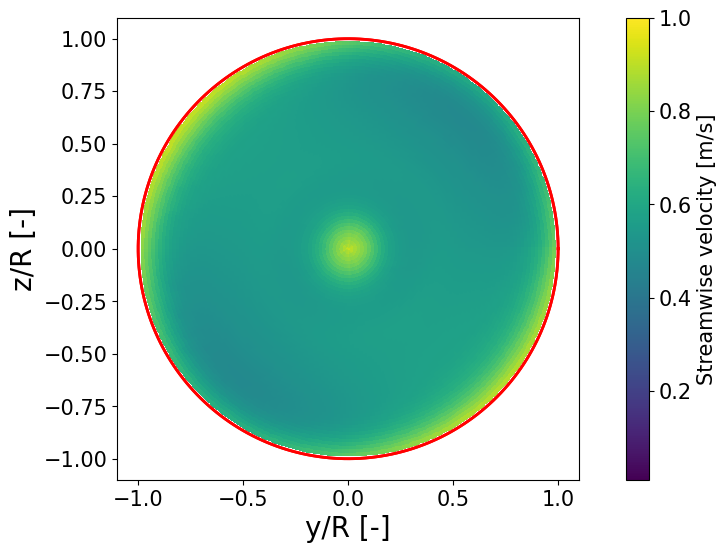

In [70]:
# Assuming you already have the data and plot set up as follows:
fig, ax = plt.subplots(figsize=(12, 6))

# Create the contour plot
# cs = ax.pcolormesh(y_new_2, z_new_2, u_new,vmin=0.48,vmax=1,cmap='viridis')
# cs = ax.pcolormesh(y, z, ws,cmap='viridis')
# cs = ax.pcolormesh(y, z, wsn4,cmap='seismic')

# cs = ax.pcolormesh(y, z, wsn4,cmap='seismic',vmin=0.6,vmax=1.4)
# cs = ax.pcolormesh(y, z, wdn4*180/np.pi,cmap='seismic',vmin=-1,vmax=1)

#aoa
aoa_rt  = interp_polars(cl_r,cl_t,cl_R_new,cl_T_new,vd)

cs = ax.pcolormesh(cl_x_new, cl_y_new, aoa_rt/wrfles_data[count]['uinf'], cmap='viridis', vmin=0.01, vmax=1)


HR = [1]
hubx = HR * np.cos(np.linspace(0,2*np.pi,250))
huby = HR * np.sin(np.linspace(0,2*np.pi,250))
ax.plot(hubx,huby,color='r',linewidth=2)
ax.plot(hubx,huby,color='r',linewidth=2)


# Add the colorbar
cbar = fig.colorbar(cs, ax=ax, orientation='vertical')
cbar.set_label('Streamwise velocity [m/s]', fontsize=15)
cbar.ax.tick_params(labelsize=15)

# Make the axes equal
ax.set_aspect('equal', 'box')

# Optionally, you can add labels to the axes if needed
ax.set_xlabel('y/R [-]', fontsize=20)
ax.set_ylabel('z/R [-]', fontsize=20)
ax.tick_params(labelsize=15)

# Show the plot
plt.show()


/tmp/ipykernel_1261488/1913447215.py:15: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cs = ax.pcolormesh(cl_x_new, cl_y_new, 1 - aoa_rt/wrfles_data[count]['uinf'], cmap='viridis', vmin=0, vmax=0.5)


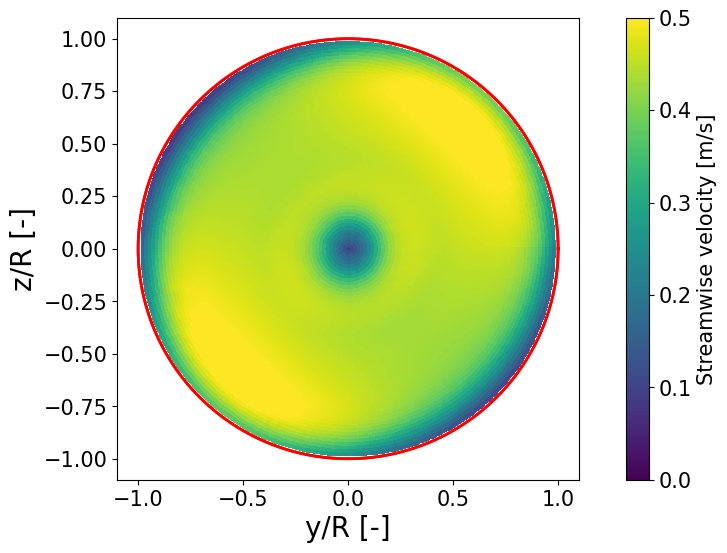

In [71]:
# Assuming you already have the data and plot set up as follows:
fig, ax = plt.subplots(figsize=(12, 6))

# Create the contour plot
# cs = ax.pcolormesh(y_new_2, z_new_2, u_new,vmin=0.48,vmax=1,cmap='viridis')
# cs = ax.pcolormesh(y, z, ws,cmap='viridis')
# cs = ax.pcolormesh(y, z, wsn4,cmap='seismic')

# cs = ax.pcolormesh(y, z, wsn4,cmap='seismic',vmin=0.6,vmax=1.4)
# cs = ax.pcolormesh(y, z, wdn4*180/np.pi,cmap='seismic',vmin=-1,vmax=1)

#aoa
aoa_rt  = interp_polars(cl_r,cl_t,cl_R_new,cl_T_new,vd)

cs = ax.pcolormesh(cl_x_new, cl_y_new, 1 - aoa_rt/wrfles_data[count]['uinf'], cmap='viridis', vmin=0, vmax=0.5)


HR = [1]
hubx = HR * np.cos(np.linspace(0,2*np.pi,250))
huby = HR * np.sin(np.linspace(0,2*np.pi,250))
ax.plot(hubx,huby,color='r',linewidth=2)
ax.plot(hubx,huby,color='r',linewidth=2)


# Add the colorbar
cbar = fig.colorbar(cs, ax=ax, orientation='vertical')
cbar.set_label('Streamwise velocity [m/s]', fontsize=15)
cbar.ax.tick_params(labelsize=15)

# Make the axes equal
ax.set_aspect('equal', 'box')

# Optionally, you can add labels to the axes if needed
ax.set_xlabel('y/R [-]', fontsize=20)
ax.set_ylabel('z/R [-]', fontsize=20)
ax.tick_params(labelsize=15)

# Show the plot
plt.show()


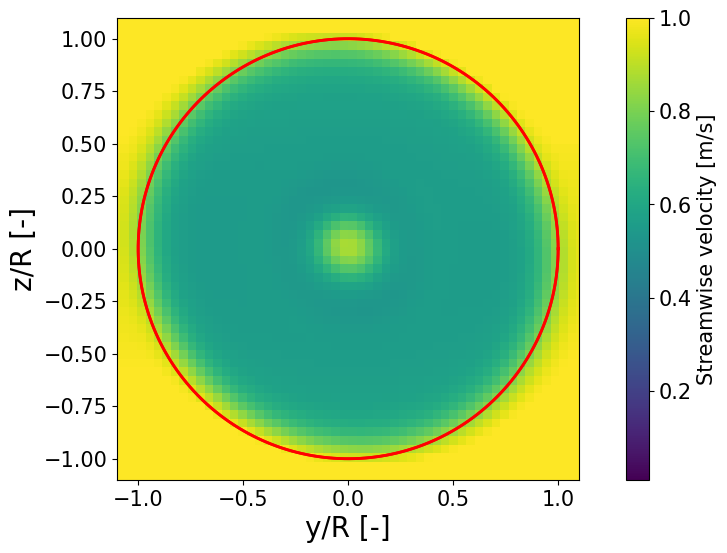

In [72]:
# Assuming you already have the data and plot set up as follows:
fig, ax = plt.subplots(figsize=(12, 6))

# Create the contour plot
# cs = ax.pcolormesh(y_new_2, z_new_2, u_new,vmin=0.48,vmax=1,cmap='viridis')
cs = ax.pcolormesh(y, z, ws,cmap='viridis', vmin=0.01, vmax=1)
# cs = ax.pcolormesh(y, z, wsn4,cmap='seismic')

# cs = ax.pcolormesh(y, z, wsn4,cmap='seismic',vmin=0.6,vmax=1.4)
# cs = ax.pcolormesh(y, z, wdn4*180/np.pi,cmap='seismic',vmin=-1,vmax=1)

#aoa
# aoa_rt  = interp_polars(cl_r,cl_t,cl_R_new,cl_T_new,vd)

# cs = ax.pcolormesh(cl_x_new, cl_y_new, aoa_rt/wrfles_data[count]['uinf'], cmap='viridis', vmin=0.01, vmax=1)


HR = [1]
hubx = HR * np.cos(np.linspace(0,2*np.pi,250))
huby = HR * np.sin(np.linspace(0,2*np.pi,250))
ax.plot(hubx,huby,color='r',linewidth=2)
ax.plot(hubx,huby,color='r',linewidth=2)


# Add the colorbar
cbar = fig.colorbar(cs, ax=ax, orientation='vertical')
cbar.set_label('Streamwise velocity [m/s]', fontsize=15)
cbar.ax.tick_params(labelsize=15)

# Make the axes equal
ax.set_aspect('equal', 'box')

# Optionally, you can add labels to the axes if needed
ax.set_xlabel('y/R [-]', fontsize=20)
ax.set_ylabel('z/R [-]', fontsize=20)
ax.tick_params(labelsize=15)
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

# Show the plot
plt.show()


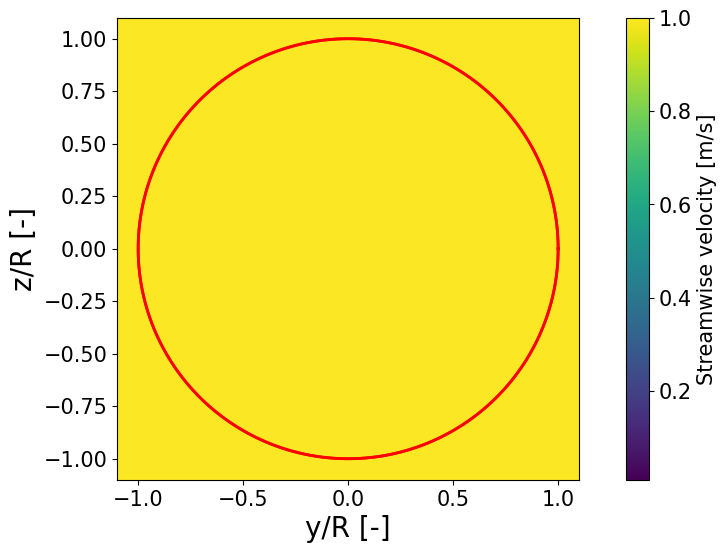

In [43]:
# Assuming you already have the data and plot set up as follows:
fig, ax = plt.subplots(figsize=(12, 6))

# Create the contour plot
# cs = ax.pcolormesh(y_new_2, z_new_2, u_new,vmin=0.48,vmax=1,cmap='viridis')
cs = ax.pcolormesh(y, z, wsn4,cmap='viridis', vmin=0.01, vmax=1)
# cs = ax.pcolormesh(y, z, wsn4,cmap='seismic')

# cs = ax.pcolormesh(y, z, wsn4,cmap='seismic',vmin=0.6,vmax=1.4)
# cs = ax.pcolormesh(y, z, wdn4*180/np.pi,cmap='seismic',vmin=-1,vmax=1)

#aoa
# aoa_rt  = interp_polars(cl_r,cl_t,cl_R_new,cl_T_new,vd)

# cs = ax.pcolormesh(cl_x_new, cl_y_new, aoa_rt/wrfles_data[count]['uinf'], cmap='viridis', vmin=0.01, vmax=1)


HR = [1]
hubx = HR * np.cos(np.linspace(0,2*np.pi,250))
huby = HR * np.sin(np.linspace(0,2*np.pi,250))
ax.plot(hubx,huby,color='r',linewidth=2)
ax.plot(hubx,huby,color='r',linewidth=2)


# Add the colorbar
cbar = fig.colorbar(cs, ax=ax, orientation='vertical')
cbar.set_label('Streamwise velocity [m/s]', fontsize=15)
cbar.ax.tick_params(labelsize=15)

# Make the axes equal
ax.set_aspect('equal', 'box')

# Optionally, you can add labels to the axes if needed
ax.set_xlabel('y/R [-]', fontsize=20)
ax.set_ylabel('z/R [-]', fontsize=20)
ax.tick_params(labelsize=15)
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

# Show the plot
plt.show()


In [73]:
# Mask points where r > R
mask = r <= 1.5
r_filtered     = r[mask]
theta_filtered = theta[mask]
ws_filtered    = ws[mask]
wd_filtered    = wd[mask]

In [74]:
def interp_polars(r,t,R,T,data):
    interpolator = RegularGridInterpolator(
        (r, t), 
        data, 
        bounds_error=False, 
        fill_value=None  # Enables extrapolation
    )

    # Interpolation points
    points_new = np.column_stack((R.ravel(), T.ravel()))

    # Interpolate to new points
    return interpolator(points_new).reshape(R.shape)

In [75]:
# Interpolate to new polar grid
r_new = np.linspace(0.0, 0.99999, 60)  # 50 points in r
theta_new = np.linspace(0, 2 * np.pi, 360)  # 100 points in theta
Theta_new, R_new = np.meshgrid(theta_new, r_new)

In [76]:
# Convert new polar grid to Cartesian for interpolation
X_new = R_new * np.sin(Theta_new)
Y_new = R_new * np.cos(Theta_new)

In [77]:
# Interpolate data to the new polar grid
ws_rt = griddata(
    points=(y[mask], z[mask]),
    values=ws_filtered,
    xi=(X_new, Y_new),
    method='linear'
)
# Interpolate data to the new polar grid
wd_rt = griddata(
    points=(y[mask], z[mask]),
    values=wd_filtered,
    xi=(X_new, Y_new),
    method='linear'
)

In [78]:
# Initialize rotor with increased radial resolution.
rotor = IEA10MW()

bem = BEM(rotor=rotor, geometry=BEMGeometry(Nr=60, Ntheta=360), aerodynamic_model=KraghAerodynamics(), tiploss_model=NoTipLoss(), momentum_model=ConstantInduction(), tangential_induction_model=NoTangentialInduction())

In [79]:
pitch, tsr, yaw = np.deg2rad(0), 10.634, np.deg2rad(0.0)
sol = bem(pitch, tsr, yaw, U=ws_rt, wdir=wd_rt)

In [56]:
# aoa_rt  = interp_polars(cl_r,cl_t,cl_R_new,cl_T_new,vd)
# aoa_rt  = interp_polars(cl_r,cl_t,cl_R_new,cl_T_new,ws_rt * np.cos(wd_rt))
aoa_rt  = ws_rt * wrfles_data[count]['uinf'] * np.cos(wd_rt)


In [53]:
aoa_rt

array([[0.93873274, 0.93873274, 0.93873274, ..., 0.93873274, 0.93873274,
        0.93873274],
       [0.9397715 , 0.93976851, 0.93976523, ..., 0.9397766 , 0.93977419,
        0.9397715 ],
       [0.93438603, 0.93438702, 0.93439723, ..., 0.93441168, 0.93439425,
        0.93438603],
       ...,
       [0.74781115, 0.74746478, 0.74781713, ..., 0.74803196, 0.74756813,
        0.74781115],
       [0.78304829, 0.7826511 , 0.78281797, ..., 0.78315852, 0.78275805,
        0.78304829],
       [0.81830335, 0.81790622, 0.81811889, ..., 0.81840311, 0.81802327,
        0.81830335]], shape=(60, 360))

In [80]:
1/Ad * np.trapezoid(np.trapezoid((1- aoa_rt.T) * cl_R_new[:,0] * (wrfles_data[count]['diameter']/2), cl_R_new[:,0] * (wrfles_data[count]['diameter']/2)), cl_T_new[0,:])

np.float64(-2.9129836778912517)

In [81]:
1/Ad * np.trapezoid(np.trapezoid((1- aoa_rt.T/wrfles_data[count]['uinf']) * cl_R_new[:,0] * (wrfles_data[count]['diameter']/2), cl_R_new[:,0] * (wrfles_data[count]['diameter']/2)), cl_T_new[0,:])

np.float64(0.40553250201655394)

In [55]:
1/Ad * np.trapezoid(np.trapezoid((1- (sol.U('sector') * np.cos(sol.wdir('sector'))).T) * sol.geom.mu * (wrfles_data[count]['diameter']/2), sol.geom.mu * (wrfles_data[count]['diameter']/2)), sol.geom.theta)

np.float64(0.3755722857166954)

In [34]:
cl_R_new[1::,0]

array([0.01661017, 0.03322034, 0.04983051, 0.06644068, 0.08305085,
       0.09966102, 0.11627119, 0.13288136, 0.14949153, 0.16610169,
       0.18271186, 0.19932203, 0.2159322 , 0.23254237, 0.24915254,
       0.26576271, 0.28237288, 0.29898305, 0.31559322, 0.33220339,
       0.34881356, 0.36542373, 0.3820339 , 0.39864407, 0.41525424,
       0.43186441, 0.44847458, 0.46508475, 0.48169492, 0.49830508,
       0.51491525, 0.53152542, 0.54813559, 0.56474576, 0.58135593,
       0.5979661 , 0.61457627, 0.63118644, 0.64779661, 0.66440678,
       0.68101695, 0.69762712, 0.71423729, 0.73084746, 0.74745763,
       0.7640678 , 0.78067797, 0.79728814, 0.81389831, 0.83050847,
       0.84711864, 0.86372881, 0.88033898, 0.89694915, 0.91355932,
       0.93016949, 0.94677966, 0.96338983, 0.98      ])

In [88]:
1/Ad * np.trapezoid(np.trapezoid((1- (aoa_rt.T)[:,1::]/wrfles_data[count]['uinf']) * cl_R_new[1::,0] * (wrfles_data[count]['diameter']/2), cl_R_new[1::,0] * (wrfles_data[count]['diameter']/2)), cl_T_new[0,:])

np.float64(0.4054984234425372)

In [86]:
ref_ind = 0.3571986067996543

In [82]:
abs((ref_ind - 0.40553250201655394) / 0.40553250201655394) * 100

11.053531958761377

In [87]:
abs((0.40553250201655394 - ref_ind) / ref_ind) * 100

13.531378425562885

In [84]:
1/Ad * np.trapezoid(np.trapezoid((1- (sol.U('sector') * np.cos(sol.wdir('sector'))).T) * sol.geom.mu * (wrfles_data[count]['diameter']/2), sol.geom.mu * (wrfles_data[count]['diameter']/2)), sol.geom.theta)

np.float64(0.4246618411967054)

In [85]:
abs((0.4246618411967054 - 0.375572285716695) / 0.375572285716695) * 100

13.070601145751231